# Webscraping Workshop

* So far we took the datasource for granted
* We got `.csv`s, `.xlsx`'s, etc. ... data we got with SQL-queries
* What do we do, if there are **no datasets**?
* Webscraping = Getting data you're "not supposed" to get. What does "not supposed to get" mean? Unclear...
* In **contrast**: API's. API="Here is the interface for you, I'm inviting you to buid code around it, so you can get my data in an automated way"
* Automated process of getting data from a website
* Always try to avoid webscraping, if you can get the information otherwise - may not be worth the time
* Because: **Typical scenario**,
    * you build a webscraping routing in Python,
    * spend maybe 2 weeks on it, getting data for your department,
    * you get data out of it, but then the creators of that website make a significant change
    * And your webscraping script is broken and you have to fix it.
    * don't threfore invest time in making code robust! It might be for the birds tomorrow anyway.
    
 Today we're going to scrape a ranking on course report:
https://www.coursereport.com/best-coding-bootcamps

* First we have to understand:
**How do computers see websites?** 

* Because the way a website is designed is obviously very different compared to how a computer sees it (UX/UI, webdesign, a whole industry)

* [SHOW INSPECT ELEMENT]
* html = hypertext markup language
* What does all these characters in the code mean? Chevron characters (`<>`), these `div`'s etc...
* Good news: As data analysts, we don't have to exactly know.
* All we basically need to know, is 
    * How to find within the HTML code what we're interested in [INSPECT ELEMENT]
    * And a bit of knowledge about the HTML DOM (Document Object Model)
    
* [SHOW, EXPLAIN DOM] https://www.w3schools.com/whatis/whatis_htmldom.asp
    * DOM tree tells your browser, how to render the website
    * Onion model!
    * `<body>` actual content
    * `<head>` with a lot of metadata, tracking cookies, things that have to load in the background (`.js`'s)
    
* So what do we want?
    * Aim: a Pandas dataframe !
    
School   | rating | reviews  | no. of courses |
---------| ------ | -------- | -------------- |
Ironhack | 4.5    | 345      | 7              |

* But: If I only look at the DOM tree, what should I look for?
    * Take advantage of the tags!
    * The tags are your **breadcrumbs**
    * Best **breadcumbs** for data analysts: `<ul>` for "unordered list", every item is an `<li>` tag:
    ```html
    <ul>
        <li> ... </li>
        <li> ... </li>
        <li> ... </li>
    </ul>
    ```
    
* Webscraping: Following the breadcumbs.
    * How in Python?
    * The following-the-breadcrumbs or Walking the DOM-tree library is called `BeautifulSoup` (check https://anaconda.org/anaconda/beautifulsoup4 ), which is in some way a sorting box. Takes all the content of the html code

# Scraping coursereport!

### our plan:

1. Send `GET` **request** to https://www.coursereport.com/best-coding-bootcamps to get the html code
2. Throw html into a **soup**
3. Extract desired data
    * rank
    * name
    * avg. rating
    * stars
    * no. of reviews
    * locations
    * description

# Install necessary packages into our environment

making sure we have the package `request` and `beautifulsoup4` installed, otherwise install it with

```bash
$ conda install -c anaconda requests
$ conda install -c anaconda beautifulsoup4 
```

In [ ]:
!conda list

# import necessary libraries

In [1]:
import requests
import urllib
from bs4 import BeautifulSoup

import pandas as pd
import re  # for later

# 1. get HTML

First we need to send the `GET` request to get the whole HTML code, to then in a next step throw it into our soup

In [2]:
url = "https://www.coursereport.com/best-coding-bootcamps"

In [3]:
requests.get(url)

<Response [200]>

Code `200` means: Success! Reassure for example here: [httpstatuscodes](https://www.restapitutorial.com/httpstatuscodes.html)

what happens if we have a typo?

In [4]:
requests.get("https://www.coursereport.com/best-cooding-bootcamps")

<Response [404]>

let's store the response object into a variable, so that we can work with it more easily

In [5]:
response = requests.get(url)

In [6]:
print(response.status_code)

200


Code `200` means: Success! Reassure for example here: [httpstatuscodes](https://www.restapitutorial.com/httpstatuscodes.html)

Let's check the response's content:

In [7]:
response.content

b'<!DOCTYPE html><html><head>\n<script>window.NREUM||(NREUM={});NREUM.info={"beacon":"bam-cell.nr-data.net","errorBeacon":"bam-cell.nr-data.net","licenseKey":"04fb2dfdee","applicationID":"3752730","transactionName":"clsKERQNDlxQRB0EA0JAOwYJBgteUmlQCQlFVwUIFhFNWVtSVx4=","queueTime":3,"applicationTime":215,"agent":""}</script>\n<script>(window.NREUM||(NREUM={})).loader_config={xpid:"UA8GVVFQGwAHUVNVBAE=",licenseKey:"04fb2dfdee",applicationID:"3752730"};window.NREUM||(NREUM={}),__nr_require=function(t,e,n){function r(n){if(!e[n]){var i=e[n]={exports:{}};t[n][0].call(i.exports,function(e){var i=t[n][1][e];return r(i||e)},i,i.exports)}return e[n].exports}if("function"==typeof __nr_require)return __nr_require;for(var i=0;i<n.length;i++)r(n[i]);return r}({1:[function(t,e,n){function r(t){try{c.console&&console.log(t)}catch(e){}}var i,o=t("ee"),a=t(23),c={};try{i=localStorage.getItem("__nr_flags").split(","),console&&"function"==typeof console.log&&(c.console=!0,i.indexOf("dev")!==-1&&(c.dev=!

`b""` - a byte string, not important for us right now
similar to `f""` string... You can look it up

Somewhere in there is our data
Beautifulsoup is going to help us find it

# 2. Creating a soup

[OPEN BROWSER WITH INSPECTED ELEMENT SIDE-BY-SIDE TO NOTEBOOK]

In [8]:
soup = BeautifulSoup(response.content, "html.parser")  # using the python built-in parser here

Having a not appropriate parser is a common source of problems when you try to webscrape (for example heavy html-5 content). So changing the parser can solve this problem, check https://www.crummy.com/software/BeautifulSoup/bs4/doc/#installing-a-parser

* not appropriate parser -> not all content in the response

In [9]:
soup

<!DOCTYPE html>
<html><head>
<script>window.NREUM||(NREUM={});NREUM.info={"beacon":"bam-cell.nr-data.net","errorBeacon":"bam-cell.nr-data.net","licenseKey":"04fb2dfdee","applicationID":"3752730","transactionName":"clsKERQNDlxQRB0EA0JAOwYJBgteUmlQCQlFVwUIFhFNWVtSVx4=","queueTime":3,"applicationTime":215,"agent":""}</script>
<script>(window.NREUM||(NREUM={})).loader_config={xpid:"UA8GVVFQGwAHUVNVBAE=",licenseKey:"04fb2dfdee",applicationID:"3752730"};window.NREUM||(NREUM={}),__nr_require=function(t,e,n){function r(n){if(!e[n]){var i=e[n]={exports:{}};t[n][0].call(i.exports,function(e){var i=t[n][1][e];return r(i||e)},i,i.exports)}return e[n].exports}if("function"==typeof __nr_require)return __nr_require;for(var i=0;i<n.length;i++)r(n[i]);return r}({1:[function(t,e,n){function r(t){try{c.console&&console.log(t)}catch(e){}}var i,o=t("ee"),a=t(23),c={};try{i=localStorage.getItem("__nr_flags").split(","),console&&"function"==typeof console.log&&(c.console=!0,i.indexOf("dev")!==-1&&(c.dev=!0),

looks ugly, let's print a bit "prettier"

In [10]:
soup.prettify()

'<!DOCTYPE html>\n<html>\n <head>\n  <script>\n   window.NREUM||(NREUM={});NREUM.info={"beacon":"bam-cell.nr-data.net","errorBeacon":"bam-cell.nr-data.net","licenseKey":"04fb2dfdee","applicationID":"3752730","transactionName":"clsKERQNDlxQRB0EA0JAOwYJBgteUmlQCQlFVwUIFhFNWVtSVx4=","queueTime":3,"applicationTime":215,"agent":""}\n  </script>\n  <script>\n   (window.NREUM||(NREUM={})).loader_config={xpid:"UA8GVVFQGwAHUVNVBAE=",licenseKey:"04fb2dfdee",applicationID:"3752730"};window.NREUM||(NREUM={}),__nr_require=function(t,e,n){function r(n){if(!e[n]){var i=e[n]={exports:{}};t[n][0].call(i.exports,function(e){var i=t[n][1][e];return r(i||e)},i,i.exports)}return e[n].exports}if("function"==typeof __nr_require)return __nr_require;for(var i=0;i<n.length;i++)r(n[i]);return r}({1:[function(t,e,n){function r(t){try{c.console&&console.log(t)}catch(e){}}var i,o=t("ee"),a=t(23),c={};try{i=localStorage.getItem("__nr_flags").split(","),console&&"function"==typeof console.log&&(c.console=!0,i.indexOf

In [11]:
type(soup)

bs4.BeautifulSoup

how do we deal with it in Python?
By addressing various attributes of our soup:

In [12]:
soup.body

<body><nav class="navbar navbar-cr navbar-fixed-top" role="navigation"><div class="container-fluid" itemscope="" itemtype="http://schema.org/Organization"><div class="navbar-header"><button aria-expanded="false" class="navbar-toggle collapsed" data-target="#navbar-collapse" data-toggle="collapse" type="button"><span class="sr-only">Toggle navigation</span><span class="icon-bar"></span><span class="icon-bar"></span><span class="icon-bar"></span></button><a class="navbar-brand" href="/" itemprop="url"><svg height="40px" width="113px" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"><image height="40px" width="113px" x="0px" xlink:href="data:img/png;base64,iVBORw0KGgoAAAANSUhEUgAAC0YAAAQACAQAAADVSGApAAAABGdBTUEAALGPC/xhBQAAACBjSFJNAAB6JgAAgIQAAPoAAACA6AAAdTAAAOpgAAA6mAAAF3CculE8AAAAAmJLR0QA/4ePzL8AAAAHdElNRQfkBRMGEi8c5bUNAACAAElEQVR42uzdeYBNdf/A8a8xTdKYJElIpzHGGBpj0pDdWJN935fsZAtJkiRJkmwJSfY9+76NfR3GGENjTOcpSZLGJGnS+P2hflFj7p27fc459/36/dPveZ7M++Lcc+7nfs/3ZLutY

In [13]:
soup.head

<head>
<script>window.NREUM||(NREUM={});NREUM.info={"beacon":"bam-cell.nr-data.net","errorBeacon":"bam-cell.nr-data.net","licenseKey":"04fb2dfdee","applicationID":"3752730","transactionName":"clsKERQNDlxQRB0EA0JAOwYJBgteUmlQCQlFVwUIFhFNWVtSVx4=","queueTime":3,"applicationTime":215,"agent":""}</script>
<script>(window.NREUM||(NREUM={})).loader_config={xpid:"UA8GVVFQGwAHUVNVBAE=",licenseKey:"04fb2dfdee",applicationID:"3752730"};window.NREUM||(NREUM={}),__nr_require=function(t,e,n){function r(n){if(!e[n]){var i=e[n]={exports:{}};t[n][0].call(i.exports,function(e){var i=t[n][1][e];return r(i||e)},i,i.exports)}return e[n].exports}if("function"==typeof __nr_require)return __nr_require;for(var i=0;i<n.length;i++)r(n[i]);return r}({1:[function(t,e,n){function r(t){try{c.console&&console.log(t)}catch(e){}}var i,o=t("ee"),a=t(23),c={};try{i=localStorage.getItem("__nr_flags").split(","),console&&"function"==typeof console.log&&(c.console=!0,i.indexOf("dev")!==-1&&(c.dev=!0),i.indexOf("nr_dev")!==

Returning the first `div` of the header

In [14]:
soup.body.div

<div class="container-fluid" itemscope="" itemtype="http://schema.org/Organization"><div class="navbar-header"><button aria-expanded="false" class="navbar-toggle collapsed" data-target="#navbar-collapse" data-toggle="collapse" type="button"><span class="sr-only">Toggle navigation</span><span class="icon-bar"></span><span class="icon-bar"></span><span class="icon-bar"></span></button><a class="navbar-brand" href="/" itemprop="url"><svg height="40px" width="113px" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"><image height="40px" width="113px" x="0px" xlink:href="data:img/png;base64,iVBORw0KGgoAAAANSUhEUgAAC0YAAAQACAQAAADVSGApAAAABGdBTUEAALGPC/xhBQAAACBjSFJNAAB6JgAAgIQAAPoAAACA6AAAdTAAAOpgAAA6mAAAF3CculE8AAAAAmJLR0QA/4ePzL8AAAAHdElNRQfkBRMGEi8c5bUNAACAAElEQVR42uzdeYBNdf/A8a8xTdKYJElIpzHGGBpj0pDdWJN935fsZAtJkiRJkmwJSfY9+76NfR3GGENjTOcpSZLGJGnS+P2hflFj7p27fc459/36/dPveZ7M++Lcc+7nfs/3ZLutYG4l/R/Lkzdvnjy5Ah4JCAjw98+Vy98/V8BDOR7MkSNHjhwP+j2UU6nsPv7+9/5bv6fdvHnn

But which `div` is the right one? Check with [INSPECT ELEMENT]
Need to uniquely identify the div of our interest. and for that, we use the `class=...` keyword
* now we want to find `div` with `class="main-body"`

In [15]:
soup.body.find("div", class_="main-body")

<div class="main-body"><div class="sidebar"><div class="sidebar-apply-module"><a data-ga='{"category":"Click Match Link","action":"Click","label":"https://www.coursereport.com/best-coding-bootcamps"}' href="/get-matched"><span class="top">Not sure what you're <br/> looking for?</span><span class="bottom">We'll match you!</span></a></div></div><div class="longform-body container"><p class="details"></p><span class="author"><span class="icon-user"></span> By: The Course Report Team<h4 class="text-left">Last Update: 10/26/2020</h4></span><div class="row"><div class="col-md-11"><p>As the <a href="/about">leading authority</a> on coding bootcamps, the team at Course Report has been researching, tracking, and sharing the latest on the coding bootcamp industry since 2013. And each year, we use that knowledge and expertise to curate a list of the top 54 immersive coding bootcamps around the world. </p><p>In addition to reading reviews, visiting classrooms, and researching job outcomes, this li

* Note that it's `class_`, because `class` is a reserved keyword in python
* how do we find more in that? Simple method chaining
* narrowing it down, so that soup becomes smaller

In [16]:
(soup
 .body
 .find("div", class_="main-body")
 .find("div", class_="longform-body container")
 .find("div", class_="row")
 .find("div", class_="col-md-11")
 .find("ul", id="schools")
 .find_all("li")  # result is a list
)

[<li class="school-li" data-average="4.96" data-count="94" data-name="&lt;Academia de Código_&gt;"><div class="school-header"><h3><a href="/schools/academia-de-codigo_">1. &lt;Academia de Código_&gt;</a></h3><div class="banner-container"></div></div><div class="school-listing__subheader"><div><p class="ratings"><span class="icon-full_star"></span><span class="icon-full_star"></span><span class="icon-full_star"></span><span class="icon-full_star"></span><span class="icon-full_star"></span><p class="rating-number">Avg Rating: 4.96 <a href="/schools/academia-de-codigo_#reviews">(94 reviews)</a></p></p></div><p class="details"><span class="location"><span class="icon-location"></span><a href="/cities/fundao">Fundão</a>, <a href="/cities/terceira-island">Terceira Island</a>, <a href="/cities/porto">Porto</a>, and 1 more...</span><span class="courses"><span class="icon-list"></span>3 Courses</span><div class="school-listing"></div></p></div><a href="/schools/academia-de-codigo_"><div class="

let's put it in a proper list

In [17]:
school_list_items = list(soup
                         .body
                         .find("div", class_="main-body")
                         .find("div", class_="longform-body container")
                         .find("div", class_="row")
                         .find("div", class_="col-md-11")
                         .find("ul", id="schools")
                         .find_all("li")  # result is a list
                        )

In [18]:
school_list_items

[<li class="school-li" data-average="4.96" data-count="94" data-name="&lt;Academia de Código_&gt;"><div class="school-header"><h3><a href="/schools/academia-de-codigo_">1. &lt;Academia de Código_&gt;</a></h3><div class="banner-container"></div></div><div class="school-listing__subheader"><div><p class="ratings"><span class="icon-full_star"></span><span class="icon-full_star"></span><span class="icon-full_star"></span><span class="icon-full_star"></span><span class="icon-full_star"></span><p class="rating-number">Avg Rating: 4.96 <a href="/schools/academia-de-codigo_#reviews">(94 reviews)</a></p></p></div><p class="details"><span class="location"><span class="icon-location"></span><a href="/cities/fundao">Fundão</a>, <a href="/cities/terceira-island">Terceira Island</a>, <a href="/cities/porto">Porto</a>, and 1 more...</span><span class="courses"><span class="icon-list"></span>3 Courses</span><div class="school-listing"></div></p></div><a href="/schools/academia-de-codigo_"><div class="

But do we really have to walk down that way, swinging from div to div?
Answer is **no**

Ideally, this website has only one `ul` with `id="schools`

In [19]:
school_list_items = list(soup.body
                         .find("ul", id="schools")
                         .find_all("li")  # result is a list
                        )

In [22]:
school_list_items

[<li class="school-li" data-average="4.96" data-count="94" data-name="&lt;Academia de Código_&gt;"><div class="school-header"><h3><a href="/schools/academia-de-codigo_">1. &lt;Academia de Código_&gt;</a></h3><div class="banner-container"></div></div><div class="school-listing__subheader"><div><p class="ratings"><span class="icon-full_star"></span><span class="icon-full_star"></span><span class="icon-full_star"></span><span class="icon-full_star"></span><span class="icon-full_star"></span><p class="rating-number">Avg Rating: 4.96 <a href="/schools/academia-de-codigo_#reviews">(94 reviews)</a></p></p></div><p class="details"><span class="location"><span class="icon-location"></span><a href="/cities/fundao">Fundão</a>, <a href="/cities/terceira-island">Terceira Island</a>, <a href="/cities/porto">Porto</a>, and 1 more...</span><span class="courses"><span class="icon-list"></span>3 Courses</span><div class="school-listing"></div></p></div><a href="/schools/academia-de-codigo_"><div class="

So, our work process so far
1. Send the request
2. From the request, you get a response.
3. Put that into a response object
4. Put that into a soup
5. Search the soup for your relevant stuff with the right `html` tag and unique identifier

But still: I have a list of list items with the HTML code. But it's still HTML
Nevertheless: I have broken down the problem to a smaler piece.

# 3. Extract data

And our workflow is (recommended for scraping websites, but also a good problem solving approach in general)
* First get it done for one list entry, then build a for loop or sth. like that

**get rank and name**

Check first item, then browse through it using html-tags as (python) object properties:

In [23]:
school_list_items[0].div.h3.a

<a href="/schools/academia-de-codigo_">1. &lt;Academia de Código_&gt;</a>

In [24]:
school_list_items[0].div.h3.a.contents

['1. <Academia de Código_>']

In [25]:
school_list_items[0].div.h3.a.text

'1. <Academia de Código_>'

So it seems: this way we can get the title for one school!

**get avg. rating**

In [26]:
school_list_items[0].find("p", class_="rating-number").text

'Avg Rating: 4.96 (94 reviews)'

**get stars**

more tricky! [INSPECT HOW STARS ARE WRITTEN INTO CODE]
* all stars are part of a `<p class="ratings">`
* with subsequent nested `<span>` tags

**Get no. of reviews**

In [27]:
school_list_items[0].find("p", class_="ratings").find_all("span")

[<span class="icon-full_star"></span>,
 <span class="icon-full_star"></span>,
 <span class="icon-full_star"></span>,
 <span class="icon-full_star"></span>,
 <span class="icon-full_star"></span>]

let's park it like that. We'll to the "processing later" in functions, where we turn this in actual numbers

**get locations**

In [28]:
school_list_items[0].find("span", class_="location")

<span class="location"><span class="icon-location"></span><a href="/cities/fundao">Fundão</a>, <a href="/cities/terceira-island">Terceira Island</a>, <a href="/cities/porto">Porto</a>, and 1 more...</span>

Not exactly what we want, we want all the `a` tags

In [29]:
school_list_items[0].find("span", class_="location").find_all("a")

[<a href="/cities/fundao">Fundão</a>,
 <a href="/cities/terceira-island">Terceira Island</a>,
 <a href="/cities/porto">Porto</a>]

Closer! Let's get only the locations! [IDEAS?]

what are the individual elements of that? They are tags!

In [30]:
type(school_list_items[0].find("span", class_="location").find_all("a")[0])

bs4.element.Tag

and every tag has a `text` attribute

In [31]:
[x.text for x in school_list_items[0].find("span", class_="location").find_all("a")]

['Fundão', 'Terceira Island', 'Porto']

Done with the locations!

**get description**

it's under `<p>` tag in a `<p class="description">`

In [31]:
school_list_items[0].find("p", class_="description").p.text

'Founded in 2015, <Academia de Código_> offers a 14-week, full-time intensive, immersive,\xa0full-stack programming bootcamp, and a 10-week intensive and immersive Java and OutSystems bootcamp\xa0with campuses in Lisbon, Oporto, Fundão, and Terceira Island, Portugal. <Academia de Código_> is a social impact startup committed to bringing talented minds out of unemployment. <Academia de Código_>\'s immersive programming bootcamps welcome beginners of all ages (over 18) and backgrounds (degree not needed) as long as they are willing to fully and passionately commit\xa0to becoming professional\xa0junior\xa0software developers within a short period of time.\xa0Students are guided through\xa0the course by a team of instructors who are graduates of the bootcamp. <Academia de Código_> describes their teaching methods as "peculiar" and aimed at training student to write clean code.'

Aaaand, we're done. First iteration is complete. If it works for one school, it should work for the others in a similar - if not the same - way!

If we want to do it the same way - this is a case for functions!

# 3.1. create functions to extract individual data points

* good practice: write functions that are small, that do only one thing and one thing only
* image you write all that we now have found out in one function, then, if the webdevs of that website, they make changes to let's say how the stars are programmed, then your entire dataframe generation will fail.
* this way, if we write a function for every of these extraction steps, only one step will fail, and only one column of your later dataframe has an empty column or null values in it
* then build a layer on top, that takes this functions, gathers the values, process them further etc...
* this is the software development 1-on-1. Atomize your steps, so that changes on on thing affect as less as possible other things as possible should they break

For the following, test regex on https://regex101.com/

In [32]:


def get_rank(list_item):
    """
    list_item: a school list item
    returns: the rank of that school
    """
    # rank pattern:
    # ^    starts with
    # d    a digit
    # {1,2}   maybe there's 1 or 2
    rank_pattern = r"^\d{1,2}"
    school = list_item.div.h3.a.text
    return int(re.findall(rank_pattern, school)[0])

# [CHECK ON REGEX101 if it works]

In [33]:
sample = school_list_items[3]

get_rank(sample)

4

In [34]:
def get_name(list_item):
    # name pattern
    # all of the previous
    # \.   then a period
    # \s   then a whitespace
    # ()   then take whatever follows there
    # .    any character
    # +    one or more
    name_pattern = r"^\d{1,2}\.\s(.+)"
    school = list_item.div.h3.a.text
    return re.findall(name_pattern, school)[0]

In [35]:
# lets try it out
sample = school_list_items[4]
get_name(sample)

'BrainStation'

**get rating**

In [36]:
def get_rating(list_item):
    """
    returns rating of school as float
    """
    rating_pattern = r"^Avg Rating:\s(\d\.\d{2})"
    text = list_item.find('p', class_ = "rating-number").text
    return float(re.findall(rating_pattern, text)[0])

In [37]:
sample.find('p', class_ = "rating-number").text

'Avg Rating: 4.66 (531 reviews)'

In [38]:
get_rating(sample)

4.66

**get_reviews**

In [39]:
def get_reviews(list_item):
    # pattern here
    # \(        opening parenthesis
    # (\d+)     we want anything in the parenthesis that is 1 or mor
    #           digits
    # \s        whitespace
    # reviews   the word reviews
    # \)        parenthesis
    # $         endswith
    review_pattern = r"\((\d+)\sreviews\)$"
    text = list_item.find("p", class_="rating-number").text
    return int(re.findall(review_pattern, text)[0])

In [40]:
get_reviews(sample)

531

**get stars**

Now the tricky one: stars.
We need to get the class name out of a tag.
This is how we do that:

In [41]:
sample.find('p', class_="ratings").find_all("span")

[<span class="icon-full_star"></span>,
 <span class="icon-full_star"></span>,
 <span class="icon-full_star"></span>,
 <span class="icon-full_star"></span>,
 <span class="icon-half_star"></span>]

In [42]:
sample.find('p', class_="ratings").find_all("span")[0]

<span class="icon-full_star"></span>

In [43]:
# asking for the class sort of works like a dictionary:
sample.find('p', class_="ratings").find_all("span")[0]['class']

['icon-full_star']

In [44]:
sample.find('p', class_="ratings").find_all("span")[0]['class'][0]

'icon-full_star'

It get's messy, but we're nearly there.
Now we need to count how often `span` tags with `icon-full_star` classes (should yield 1) are in the sample and how often with `icon-half_star` (should yield 0.5) and then add the result together. For that we define a dictionary, which class string corresponds to how many stars:

In [45]:
stars_dct = {"icon-full_star" : 1,
            "icon-half_star": 0.5,
            }

print(stars_dct["icon-full_star"])
print(stars_dct["icon-half_star"])

1
0.5


In [46]:
def get_stars(list_item):
    # we need our dictionary
    stars_dct = {"icon-full_star" : 1,
            "icon-half_star": 0.5,
            }
    
    # now here comes the stars list in the list item
    stars_list = list_item.find('p', class_="ratings").find_all("span")
    
    # define a result for the number of stars
    result = 0

    for star in stars_list:
        # star['class'][0] is now either "icon-full_star" or 
        # "icon-half_star". So we put this into the dict
        result += stars_dct[star['class'][0]]
    return result

In [47]:
get_stars(sample)

4.5

**get locations**

In [48]:
def get_locations(list_item):
    return [x.text for x in list_item
            .find('span', class_="location")
            .find_all("a")]

In [49]:
get_locations(sample)

['New York City', 'Vancouver', 'Toronto']

When we put this into a dataframe, let's turn this into a pipe ("`|`") delimited list:

In [50]:
"|".join(['A','B','C'])

'A|B|C'

In [51]:
def get_locations(list_item):
    return "|".join([x.text for x in list_item
                     .find('span', class_="location")
                     .find_all("a")
                    ]
                   )

In [52]:
get_locations(sample)

'New York City|Vancouver|Toronto'

**get description**

In [53]:
def get_discription(list_item):
    return list_item.find("p", class_="description").p.text

# Final Act

We spend 5 hours in the kitchen, baking the cake, now we eat it all together and it's gone in 5 minutes.
create a function that processes an entire list item, that means: Create a row that we will put into our dataframe

In [54]:
def create_row(list_item):
    return {'rank': get_rank(list_item),
           'name': get_name(list_item),
           'rating': get_rating(list_item),
           'stars': get_stars(list_item),
           'reviews': get_reviews(list_item),
           'locations': get_locations(list_item),
           'description': get_discription(list_item),
           }

In [55]:
create_row(sample)

{'rank': 5,
 'name': 'BrainStation',
 'rating': 4.66,
 'stars': 4.5,
 'reviews': 531,
 'locations': 'New York City|Vancouver|Toronto',
 'description': 'BrainStation offers full-time and part-time courses in data science, design, development, marketing, and product in New York City, London, Toronto, Vancouver, and through an Online Live platform. BrainStation’s goal is to empower individuals, businesses, and brands to succeed in the digital age by offering diploma programs, certification courses, and training options across the full digital product lifecycle. BrainStation provides a collaborative, project-based learning experience, with curriculum updated on a daily basis to ensure professionals gain the skills and experience needed to succeed in their careers.'}

Now we need a list of dictionaries, where every entry is an individual school. `sample` is just one school!

In [56]:
for school in school_list_items:
    print(create_row(school))

{'rank': 1, 'name': '<Academia de Código_>', 'rating': 4.96, 'stars': 5, 'reviews': 94, 'locations': 'Fundão|Terceira Island|Porto', 'description': 'Founded in 2015, <Academia de Código_> offers a 14-week, full-time intensive, immersive,\xa0full-stack programming bootcamp, and a 10-week intensive and immersive Java and OutSystems bootcamp\xa0with campuses in Lisbon, Oporto, Fundão, and Terceira Island, Portugal. <Academia de Código_> is a social impact startup committed to bringing talented minds out of unemployment. <Academia de Código_>\'s immersive programming bootcamps welcome beginners of all ages (over 18) and backgrounds (degree not needed) as long as they are willing to fully and passionately commit\xa0to becoming professional\xa0junior\xa0software developers within a short period of time.\xa0Students are guided through\xa0the course by a team of instructors who are graduates of the bootcamp. <Academia de Código_> describes their teaching methods as "peculiar" and aimed at trai

IndexError: list index out of range

Theres's something wrong with the first, in `get_rating`. We have written the regex pattern in a way that it has to be strictly 2 decimals.

Also we haven't implemented `icon-empty_star` in `get_stars`

In [57]:
# Fixing the errors:

def get_stars(list_item):
    # we need our dictionary
    stars_dct = {"icon-full_star" : 1,
            "icon-half_star": 0.5,
                 "icon-empty_star": 0,
            }
    
    # now here comes the stars list in the list item
    stars_list = list_item.find('p', class_="ratings").find_all("span")
    
    # define a result for the number of stars
    result = 0

    for star in stars_list:
        # star['class'][0] is now either "icon-full_star" or 
        # "icon-half_star". So we put this into the dict
        result += stars_dct[star['class'][0]]
    return result

def get_rating(list_item):
    """
    returns rating of school as float
    """
    rating_pattern = r"^Avg Rating:\s(\d\.\d{1,2})"
    text = list_item.find('p', class_ = "rating-number").text
    return float(re.findall(rating_pattern, text)[0])

Looping again through all schools

In [ ]:
for school in school_list_items:
    print(create_row(school))

No errors, so let's finally cast this into a dataframe

In [62]:
df = pd.DataFrame(create_row(school) for school in school_list_items)

In [66]:
df

,rank,name,rating,stars,reviews,locations,description
0,1,<Academia de Código_>,4.96,5.0,94,Fundão|Terceira Island|Porto,"Founded in 2015, <Academia de Código_> offers ..."
1,2,Actualize,4.90,5.0,291,Chicago|Online,Actualize is a 12-week software development bo...
2,3,App Academy,4.67,4.5,908,New York City|San Francisco|Online,App Academy offers immersive web development c...
3,4,Bottega,4.46,4.5,69,Online|Salt Lake City,Bottega offers part-time and full-time tech bo...
4,5,BrainStation,4.66,4.5,531,New York City|Vancouver|Toronto,BrainStation offers full-time and part-time co...
5,6,Claim Academy,4.51,4.5,131,St. Louis,Claim Academy is a 3-month developer coding an...
6,7,Code Fellows,4.27,4.0,136,Online|Seattle,Code Fellows offers full and part-time softwar...
7,8,Code Platoon,4.96,5.0,51,Chicago,Code Platoon is a non-profit coding bootcamp l...
8,9,Coder Academy,4.74,4.5,101,Sydney|Brisbane|Melbourne,Coder Academy is an accredited Australian codi...
9,10,Coder Foundry,4.65,4.5,92,Greensboro,Coder Foundry is a North Carolina coding bootc...


now we can inspect the data further... or add them to a SQL database, maybe also in an automated fashion, so that we let's say scrape these data scripted every day once, and every row gets a timestamp, so that I can track the ranking of schools over time...

or just do some inspections... visuals

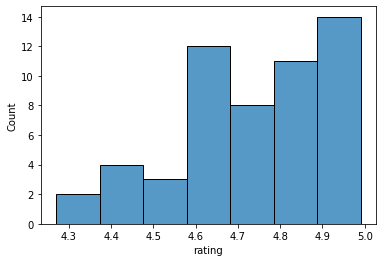

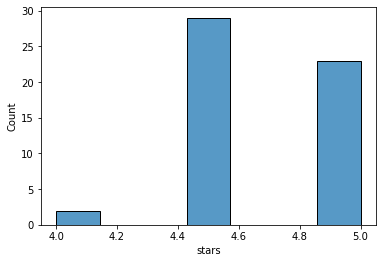

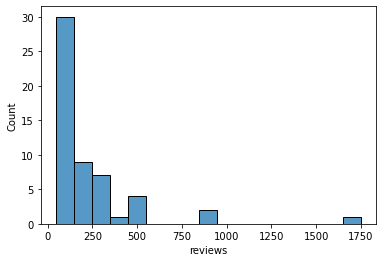

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
for col in df.drop(columns=['rank','name','locations','description'],
                   axis=1).columns:
    fig, ax = plt.subplots()
    sns.histplot(data=df, x=col, ax=ax)

# Scrape a Wikipedia page

We're trying to get this: https://en.wikipedia.org/wiki/List_of_threatened_sharks

Easy, we don't need to scrape for most wikipedia pages, because their tables contain relatively smooth html

In [68]:
list_of_dfs = pd.read_html("https://en.wikipedia.org/wiki/List_of_threatened_sharks")

In [69]:
list_of_dfs[0]

,Order,Image,Scientific name,Common name,Population trend,IUCN status,FishBase,FAO,CITESAppendix[24]
0,Mackerelshark,NaN,Alopias pelagicus,Pelagic thresher,decreasing,Vulnerable[29],[30],[31],NaN
1,Mackerelshark,NaN,Alopias superciliosus,Bigeye thresher shark,decreasing,Vulnerable[32],[33],[34],NaN
2,Mackerelshark,NaN,Alopias vulpinus,Common thresher,decreasing,Vulnerable[35],[36],[37],NaN
3,Groundshark,NaN,Atelomycterus baliensis,Bali catshark,unknown,Vulnerable[38],[39],NaN,NaN
4,Groundshark,NaN,Aulohalaelurus kanakorum,New Caledonia catshark,unknown,Vulnerable[40],[41],NaN,NaN
...,...,...,...,...,...,...,...,...,...
68,Angel shark,NaN,Squatina squatina,Angel shark,decreasing,Critically endangered[196],[197],[198],NaN
69,Angel shark,NaN,Squatina tergocellatoides,Ocellated angelshark,unknown,Vulnerable[199],[200],[201],NaN
70,Carpet shark,NaN,Stegostoma fasciatum,Zebra shark,decreasing,Vulnerable[202],[203],[204],NaN
71,Groundshark,NaN,Triakis acutipinna,Sharpfin houndshark,decreasing,Endangered[205],[206],NaN,NaN


### df of all the US counties

In [70]:
list_of_lists = pd.read_html("https://en.wikipedia.org/wiki/List_of_United_States_counties_and_county_equivalents")

In [71]:
df_counties = list_of_lists[3]

Let's quickly visualize the population in a histogram

In [72]:
import numpy as np
df_counties['log pop'] = df_counties['Population (2019 estimate)'].apply(lambda x:np.log(x) if x !=0 else 0)

Text(0, 0.5, 'Count')

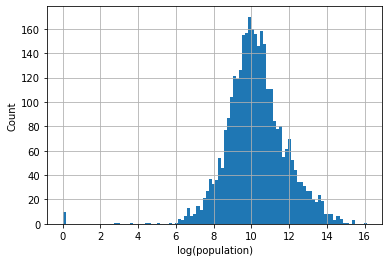

In [73]:
df_counties['log pop'].hist(bins=100)
plt.xlabel('log(population)')
plt.ylabel('Count')

# Scraping US Congress

Idea: Imagine you're working for a US company whose product is data science / data analytics services. There's rumors in the press, that Congress is planning regulations on the data science industry. The policy department approaches you with the question: "can you find out the representatives who have press releases about **data** and in a second step maybe have a NLP algorithm run on the press releases to determine the overall mood on the topic"

url = "https://www.house.gov/representatives"

In [74]:
from bs4 import BeautifulSoup
import requests

In [75]:
text = requests.get(url).text
soup = BeautifulSoup(text, parser="html5lib")

Let's create from that a soup with all the hyperlinks

In [76]:
all_urls = [a['href'] for a in soup('a') if a.has_attr('href')]   #soup('a') is short for soup.find_all('a')

In [77]:
len(all_urls)

611

Way to many, check https://en.wikipedia.org/wiki/United_States_Congress. Currently it's at 535 voting members

In [ ]:
all_urls

We only want those with the format
* `https://<name>.house.gov` or
* `http://<name>.house.gov`

How do we do that? **REGEX**!

In [79]:
# Must start with https:// or http://
# Must end with  .house.gov or .house.gov/
re_pattern = r"^https?:\/\/.*\.house\.gov\/?$"

In [80]:
assert re.match(re_pattern, "https://mcclintock.house.gov/")
assert re.match(re_pattern, "http://mcclintock.house.gov/")
assert re.match(re_pattern, "https://mcclintock.house.gov")
assert not re.match(re_pattern, "mcclintock.house.gov")

And now, let's apply:

In [81]:
good_urls = [url for url in all_urls if re.match(re_pattern, url)]

In [82]:
len(good_urls)

0

Still some duplicates in there! How to remove duplicates in a list? Trick: Convert it to a set, and convert it back to a list.

In [83]:
better_urls = list(set(good_urls))

In [84]:
len(better_urls)

0

Couple of empty seats, couple of representatives without websites... but that's good for now

Now we want to check on every of these websites the press releases (end with `/media/press-releases`). So we need to create a soup of every of these websites.

Let's first try one, proove the concept, then do it for all!

In [85]:
html = requests.get('https://mcclintock.house.gov/').text
soup = BeautifulSoup(html, "html5lib")

# Use a set, because the scraped links might appear multiple times
links = {a['href'] for a in soup('a') if "press releases" in a.text.lower()}

In [86]:
links

{'/newsroom/press-releases'}

Now let's scrape all the press releases websites from all representatives

In [87]:
from tqdm.notebook import tqdm

In [88]:
# from typing import Dict, Set
# this is just a "type hint", better for documentation and didactical purpose
# press_releases: Dict[str, Set[str]] = {}

press_releases = {}

for house_url in tqdm(better_urls):
    html = requests.get(house_url).text
    soup = BeautifulSoup(html, "html5lib")
    # pr link from that one member of congress
    pr_links = {a['href'] for a in soup('a') if "press releases" in a.text.lower()}
    print(f"{house_url} : {pr_links}")
    
    # and store all this in a dictionary
    press_releases[house_url] = pr_links
    

**Remember what we're are doing here**

We wanted to inspect all the press releases, that can be found under these links, if they mention something about "data".

We're aiming for the snippets / abstracts of every press release. They're in a `<p>` tag, so we'll use that as our first attempt:

In [89]:
text = requests.get("https://davidscott.house.gov/News/DocumentQuery.aspx?DocumentTypeID=377").text
soup = BeautifulSoup(text, "html5lib")
paragraphs = [p.get_text() for p in soup('p')]
paragraphs

['Today, Georgia Farm Bureau recognized U.S. Representative David Scott (GA-13) for receiving the Friend of Farm Bureau Award for the 116th Congress. The Friend of Farm Bureau Award is presented every two years to members of Congress who support federal legislation and regulatory initiatives to improve the lives of farmers and the rural communities they call home. “Congressman Scott has been a good ... Read more »',
 'Today, Congressman David Scott, senior Member of the U.S. House of Representatives Committee on Agriculture issued the following statement announcing he is seeking the Chairmanship of the Committee. Congressman Scott is chairman of the House Agriculture Subcommittee on Commodity Exchanges, Energy, and Credit. "I am proud to announce that I am seeking the Chairmanship of the U.S. House of Represent... Read more »',
 'This week, Representative David Scott (GA-13), along with Reps. Sanford Bishop (GA-02), Hank Johnson (GA-04) and Lucy McBath (GA-06), sent a letter to the Geo

In [90]:
def paragraph_mentions(text, keyword):
    """
    returns: True if <p> inside the text mentions the {keyword}
    """
    soup = BeautifulSoup(text, "html5lib")
    paragraphs = [p.get_text() for p in soup('p')]
    
    return any(keyword.lower() in paragraph.lower() for paragraph in paragraphs)

In [91]:
# lets test that function
text = """<body><h1>Jamil</h1><p>Caitlin</p>"""

assert paragraph_mentions(text, "Caitlin")   # inside <p>
assert not paragraph_mentions(text, "Jamil")  # not inside <p>

So let's do it for all!

In [92]:
for house_url, pr_links in tqdm(press_releases.items()):
    for pr_link in pr_links:
        url = f"{house_url}/{pr_link}"
        text = requests.get(url).text
        
        if paragraph_mentions(text, 'data'):
            print(f"{house_url}{pr_link}")
            break   # done with this house url, go to next house url

Or, wrap this in a function, which scrapes all the press releases for most members of congress, wether they've said something about a certain keyword....

In [93]:
def what_is_mentioned_by_which_congressmember(press_releases, keyword):
    url_list = []
    for house_url, pr_links in tqdm(press_releases.items()):
        for pr_link in pr_links:
            url = f"{house_url}/{pr_link}"
            text = requests.get(url).text
        
            if paragraph_mentions(text, 'data'):
                url_list.append()
                print(f"{house_url}")
                break   # done with this house url, go to next house url

# Further sources

* Parsehub, scraping html with a GUI: https://www.parsehub.com/blog/html-scraping/
* Wikipedia & datascience, working with the largest encyclopedia https://towardsdatascience.com/wikipedia-data-science-working-with-the-worlds-largest-encyclopedia-c08efbac5f5c